# TPC3 - Modelo de Ising de dimensão infinita com anisotropia

*  Não deve escrever o seu nome nem nenhum código identificador em nenhum
sítio.
* Deve entregar ESTE Notebook de Jupyter.
* O trabalho é individual. Podem e devem haver discussões com colegas
mas o resultado entregue é individual.
* Não deve acrescentar ou apagar nenhuma célula.
* Todas as explicações devem ser claras e concisas.
* É preferível fazer menos e fazer bem que muito e mal.
* A não verificação de alguma destas regras leva ao anulamento e exclusão
da prova.

In [ ]:
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
from scipy import linalg
from numba import njit
import seaborn as sns

## Pergunta 1
Nas aulas discutimos a solução do modelo de Ising de campo médio com
$N$ spins ($s=\pm1/2$). Neste trabalho de casa vamos abordar o modelo
de Ising de campo médio de spin um ($s_{i}=\pm1,0$) com anisotropia.
Considere o Hamiltoniano,
\begin{equation}
H(M,N_0,N)=\frac{1}{N}\sum_{i=1}^{N}\sum_{j=1}^{N}\left(1-s_{i}s_{j}\right)+D\sum_{i=1}^{N}s_{i}^{2}=\frac{N^{2}-M^{2}}{N}+D(N-N_{0})
\end{equation}
onde a magnetização é dada por $M=\sum_{i=1}^{N}s_{i}$ e as variáveis
de spin $s_{i}$ são $\{\pm1\}$. Para este modelo a energia é função
apenas da magnetização e do número de partículas. A densidade de estados
do sistema é obtida usando o número de spins $s_{i}=+1$ ($N_{+}$),
o número de spins $s_{i}=-1$ ($N_{-}$) e o número de spins $s_{i}=0$
($N_{0}$):
\begin{align*}
\Omega(N_{+},N_{-},N_{0}) & =\frac{N!}{N_{+}!N_{-}!N_{0}!} & N_{+} & =\frac{N-N_{0}+M}{2} & N_{-} & =\frac{N-N_{0}-M}{2}
\end{align*}
Com esta parametrização,
\begin{equation}
\Omega(M,N_{0},N)=\frac{N!}{\left(\frac{N-N_{0}+M}{2}\right)!\left(\frac{N-N_{0}-M}{2}\right)!N_{0}!}
\end{equation}
onde $M\in\{-(N-N_{0}),-(N-N_{0})+2,\dots,(N-N_{0})-2,(N-N_{0})\}$,
$N_{0}\in\{0,\dots,N\}$.

1. Calcule numericamente o valor médio exacto como função da temperatura
do módulo da magnetização para $\beta$ entre 0.1 e 1.5 e para valores
de $D\in\{0.0,0.25,0.5,0.75,1\}$
\begin{align*}
\left\langle \frac{|M|}{N}\right\rangle  & =\sum_{M,N_{0}}\frac{|M|}{N}\Omega(M,N_{0},N)\frac{e^{-\beta H(M,N_{0},N)}}{Z(\beta)}\\
Z(\beta) & =\sum_{M,N_{0}}\Omega(M,N_{0},N)e^{-\beta H(M,N_{0},N)}
\end{align*}
Sugestão: O cálculo da combinatórica envolve números muito grandes.
O idela é usar a fórmula de Stirling,
\begin{equation}
\log(n!)=n\log(n)-n+\frac{1}{2}\log(2\pi n)
\end{equation}
e notar que o valor médio fica inalterado se deslocar a energia $-\beta H(M,N_{0},N)\to-\beta H(M,N_{0},N)-C$
nas exponenciais.

$$
\Omega(M,N_0,N) = e^{\log\Omega(M,N_0,N)}
$$

Usando a fórmula do número de microstados para o log
$$
\log\Omega(M,N_{0},N)=\log N! - \log\left(\frac{N-N_0+M}{2}!\right)-\log\left(\frac{N-N_0-M}{2}!\right) - \log \left(N_0!\right)
$$
Pela fórmula de Stirling
$$
\begin{align}
\log\Omega(M,N_{0},N)&=N\log N+\frac{1}{2}\log(2\pi N) \\
&- \left(\frac{N-N_0+M}{2}\right)\log\left(\frac{N-N_0+M}{2}\right) -\frac{1}{2}\log\left(2\pi\left(\frac{N-N_0+M}{2}\right)\right)\\
&- \left(\frac{N-N_0-M}{2}\right)\log\left(\frac{N-N_0-M}{2}\right)  -\frac{1}{2}\log\left(2\pi\left(\frac{N-N_0-M}{2}\right)\right)\\
&- N_0\log N_0 - \frac{1}{2}\log(2\pi N_0)
\end{align}
$$

Portanto, a função de partição toma a forma
$$
Z(\beta) = \sum_{M,N_0} e^{-\beta H(M,N_0,N) + \log \Omega (M,N_0,N)}
$$




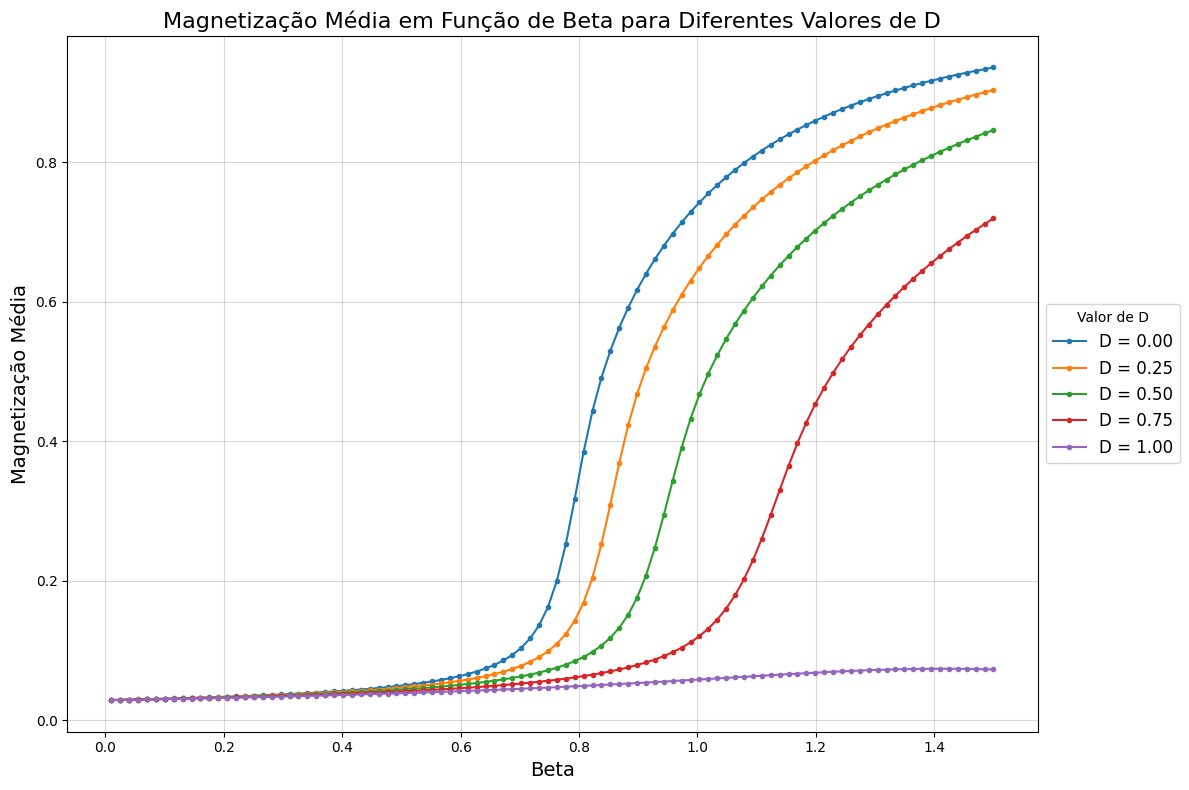

In [ ]:
@njit
def H(N, N0, M, D):
  """Calcula a energia do sistema usando o Hamiltoniano fornecido."""
  return (N**2 - M**2) / N + D * (N - N0)

@njit
def stirling(x):
  """Aproximação de Stirling para o logaritmo do fatorial."""
  if x == 0:
    return 0
  else:
    return x * np.log(x) - x + 0.5 * np.log(2 * np.pi * x)

@njit
def avg_mag(N, beta, D):
  """
  Calcula a magnetização média usando a aproximação de Stirling.

  Parâmetros:
  - N: Tamanho do sistema.
  - beta: Inverso da temperatura.
  - D: Termo de acoplamento magnético.
  """
  result = 0.0
  Z = 0.0
  N0s = np.arange(N + 1)
  for i in range(len(N0s)):
    Ms = np.arange(-(N - N0s[i]), N - N0s[i] + 2, 2)
    for j in range(len(Ms)):
      # Aproximação de Stirling para o logaritmo da função de partição
      logOmega = stirling(N) - stirling(0.5 * (N - N0s[i] + Ms[j])) - stirling(0.5 * (N - N0s[i] - Ms[j])) - stirling(N0s[i])
      Energia = H(N, N0s[i], Ms[j], D)
      exp = np.exp(-beta * Energia + logOmega)
      Z += exp
      result += np.abs(Ms[j]) / N * exp
  return result / Z

# Parâmetros do sistema
N = 512
beta = np.linspace(0.01, 1.5, 100)
Ds = np.array([0.0, 0.25, 0.5, 0.75, 1])

# Matriz para armazenar os resultados
results = np.zeros((len(beta), len(Ds)))

# Loop para calcular os resultados
for i in range(len(results)):
  for j in range(len(Ds)):
    results[i, j] = avg_mag(N, beta[i], Ds[j])

# Plot dos resultados
plt.figure(figsize=(12, 8))

for d in range(len(Ds)):
  plt.plot(beta, results[:, d], '.-', label=f'D = {Ds[d]:.2f}')

# Ajustes visuais e legenda
plt.title('Magnetização Média em Função de Beta para Diferentes Valores de D', fontsize=16)
plt.xlabel('Beta', fontsize=14)
plt.ylabel('Magnetização Média', fontsize=14)
plt.legend(title='Valor de D', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

1. Para cada temperatura a distribuição de probabilidades da magnetização
é dada por,
\begin{equation}
P_{N,\beta}(M,N_{0})=\frac{e^{\ln(\Omega(M,N_{0},N))-\beta H(M,N_{0},N)}}{Z(\beta,N)}
\end{equation}
e a distribuição de probabilidade da magnetização é dada por,
\begin{equation}
P_{N,\beta}(M)=\sum_{N_{0}}P_{N,\beta}(M,N_{0})
\end{equation}
Gere uma amostra de valores aleatórios de $M$ e $N_{0}$ com a distribução
pretendida usando o método von Neumann. Com esta amostra $\{M_{1},M_{2},\dots,M_{K}\}$

$\qquad$ a) Represente o histograma da amostra aleatória gerada e compare com
a distribuição teórica para $\beta\in\{0.1,0.5,0.75,0.9,1.0,1.05,1.1,1.2,1.5\}$
e $D\in\{0.0,0.25,0.5,0.75,1\}$.

Responda Aqui

In [ ]:
@njit
def Z(N, beta, D):

  Z = 0.0
  N0s = np.arange(N+1)
  for i in range(len(N0s)):
    Ms = np.arange(-(N-N0s[i]), N-N0s[i]+2,2)
    for j in range(len(Ms)):

      logOmega = stirling(N) - stirling(0.5*(N-N0s[i]+Ms[j])) - stirling(0.5*(N-N0s[i]-Ms[j])) - stirling(N0s[i])


      Energia = H(N,N0s[i],Ms[j],D)
      exp = np.exp(-beta*Energia + logOmega)

      Z +=  exp

  return  Z



@njit
def P(N,M,N0,beta,D):
  logOmega = stirling(N) - stirling(0.5*(N-N0+M)) - stirling(0.5*(N-N0-M)) - stirling(N0)

  Energia = H(N,N0,M,D)
  return np.exp(-beta*Energia + logOmega)  / Z(N,beta,D)


@njit
def P_final(N,M,beta,D):
  N0s = np.arange(N+1)
  P_N0s = np.zeros(len(N0s),dtype=np.double)
  for i in range(len(P_N0s)):
    Ps = P(N,M,N0s[i],beta,D)
    if np.isnan(Ps) == True:
      P_N0s[i] = 0
    else:
      P_N0s[i] = P(N,M,N0s[i],beta,D)
  return np.sum(P_N0s)

@njit
def gerar_amostras(beta,D,N,n,n_values):
  Ms = np.arange(-N,N+1,1)
  prob_aceitação = np.ones(len(Ms))

  for i in range(len(Ms)):
    prob_aceitação[i] = P_final(N,Ms[i],beta,D)

  result = np.array([0],dtype = np.int64)

  while(len(result) <= n):
    i = (np.random.rand(n_values)*len(Ms)).astype(np.int32)
    sample = Ms[i]
    i_result = np.where(np.random.rand(n_values) < prob_aceitação[i])
    r = sample[i]
    result = np.append(result,r)
  return result[1:n+1],prob_aceitação


betas = np.array([0.1,0.5,0.75,0.9,1.0,1.05,1.1,1.2,1.5])
Ds = np.array([0.0,0.25,0.5,0.75,1])

plt.hist(gerar_amostras(0.1,0.0,1000,100,100))

$\quad$(b) Meça a autocorrelação da magnetização para $\beta=1.05$,
\begin{align*}
corr_{M}(\tau)	& =\frac{\left\langle M_{i}M_{i+\tau}\right\rangle -\left\langle M_{i}\right\rangle ^{2}}{\left\langle M_{i}^{2}\right\rangle -\left\langle M_{i}\right\rangle ^{2}}\\
\left\langle M_{i}M_{i+\tau}\right\rangle &	=\frac{1}{L}\sum_{i=1}^{L}M_{i}M_{i+\tau}
\end{align*}

Responda Aqui

In [ ]:
# Responda Aqui

## Pergunta 2

Na pergunta anterior efectuamos uma simulação Monte Carlo gerando as amostras da variável $M$. Será que a amostra gerada corresponde à gerada por uma dinâmica do sistema de N spins com o Hamiltoniano,
\begin{equation*}
H=\frac{N^{2}-M^{2}}{N}+D(N-N_{0})
\end{equation*}
e com o algorítmo de Metropolis?

1. Para testar implemente o algoritmo de Metropolis para $N$ spins:

• Atribua a cada um dos $N$ spins do sistema uma variável $\pm1,0$ com probailidade uniforme.

• Considere um passo de tempo o seguinte algoritmo:

– Escolha um spin com probabilidade uniforme.

– Proponha alterar o seu valor e aceite com a probabilidade $\min\left(1,e^{-\beta\Delta H}\right)$ senão fique no mesmo estado.

Responda Aqui

In [ ]:
@njit
def inicializar_os_spins(N):
  """Inicializa os spins aleatoriamente: +1, -1, ou 0."""
  return np.random.choice(np.array([-1, 1, 0]), size=N)

@njit
def energia(N, M, D, N0):
  """
  Calcula a energia do sistema usando o Hamiltoniano fornecido.

  Parâmetros:
  - N: Numero de particulas.
  - M: Magnetização total.
  - D: Termo de acoplamento magnético.
  - N0: Número de spins neutros.
  """
  return (N**2 - M**2) / N + D * (N - N0)

@njit
def passeio(spins, N, D, num_steps, beta):
  """
  Realiza uma simulação de Monte Carlo para um sistema magnético unidimensional.

  Parâmetros:
  - spins: Array contendo os spins.
  - num_steps: Número de passos na simulação.
  - beta: Inverso da temperatura.
  """

  # Inicialização de arrays para armazenar a evolução do sistema
  energias = np.zeros(num_steps)
  magnetiz = np.zeros(num_steps)

  # Número inicial de spins neutros
  N0 = N - np.count_nonzero(spins)

  # Possíveis valores de spins
  possible_values = np.array([-1, 0, 1])

  # Inicialização da magnetização e energia inicial
  mag_i = np.sum(spins)
  magnetiz[0] = mag_i
  energias[0] = energia(N, mag_i, D, N0)

  # Loop principal da simulação
  for j in range(1, num_steps):
    # Escolhe um spin aleatório
    i = np.random.randint(N)

    # Propõe alterar o valor do spin escolhido
    new_spin_i = np.random.choice(possible_values[possible_values != spins[i]])

    # Calcula a mudança nas variáveis
    new_N0 = N0
    if spins[i] == 0:
      new_N0 -= 1
    if new_spin_i == 0:
      new_N0 += 1

    delta_M = new_spin_i - spins[i]
    delta_energia = energia(N, magnetiz[j-1] + delta_M, D, new_N0) - energia(N, magnetiz[j-1], D, N0)

    # Atualização de valores
    energias[j] = energias[j-1]
    magnetiz[j] = magnetiz[j-1]

    # Verifica se a mudança é aceita com base na probabilidade de Metropolis
    if np.random.rand() < np.exp(-beta * delta_energia):
      N0 = new_N0
      spins[i] = new_spin_i
      energias[j] += delta_energia
      magnetiz[j] += delta_M

  # Retorna os arrays de magnetização e energia ao longo do tempo
  return magnetiz, energias


2. Compare as distribuições de probabilidade assiptótica da magnetização para vários valores de $\beta$ e $D$.  

Responda Aqui

In [ ]:
sns.set(style="whitegrid")

# Tamanho da rede e termo de acoplamento magnético inicial
N = 2048
D = 0.0

# Inicialização dos spins
spins = inicializar_os_spins(N)

# Número de passos na simulação
num_steps = 1000000

# Variação de temperatura (beta) e termo de acoplamento magnético (D)
betas = np.linspace(0.1, 4.0, 50)
Ds = np.linspace(0.0, 1.0, 20)

# Matriz para armazenar os valores médios de magnetização
medio_mag = np.zeros((len(Ds), len(betas)))

# Loop sobre os valores de D
for d in range(len(Ds)):
  # Loop sobre os valores de beta
  for b in range(len(betas)):
    # Realiza a simulação de Monte Carlo
    magnetizacao_values, energy_values = passeio(spins, N, Ds[d], num_steps, betas[b])

    # Calcula o valor médio da magnetização e armazena na matriz
    medio_mag[d, b] = np.mean(abs(magnetizacao_values[20000::1000]) / N)

palette = sns.color_palette("viridis", n_colors=len(Ds))

# Plot dos resultados
plt.figure(figsize=(12, 8))
for d in range(len(Ds)):
  plt.plot(betas, medio_mag[d, :], '.-', label=f'D = {Ds[d]:.2f}', color=palette[d])

# Ajustes visuais e legenda
plt.title('Magnetização Média em Função de Beta para Diferentes Valores de D', fontsize=16)
plt.xlabel('Beta', fontsize=14)
plt.ylabel('Magnetização Média', fontsize=14)
plt.legend(title='Valor de D', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

3. Os amostras geradas são equivalentes às do primeiro problema?

Responda Aqui

### Bom Trabalho